In [1]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = '7'
import keras
import keras.layers as layers
import keras.activations as activations
%matplotlib inline
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from sklearn.metrics import f1_score
from sklearn.model_selection import train_test_split
import transformations

Using TensorFlow backend.


In [2]:
# X_test = pd.read_csv('X_test.csv',sep=',',engine='python',header=0).values
# X_train = pd.read_csv('X_train.csv',sep=',',engine='python',header=0).values
# Y_train = np.genfromtxt('y_train.csv', delimiter=',', skip_header=1)

# np.save('X_train', X_train)
# np.save('Y_train', Y_train)
# np.save('X_test', X_test)

In [104]:
X_test = np.load('X_test.npy')
X_train = np.load('X_train.npy')
y_train = np.load('Y_train.npy')

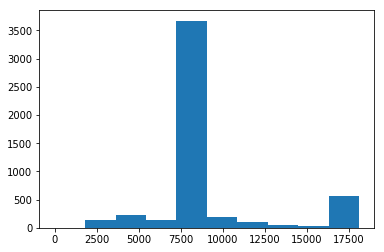

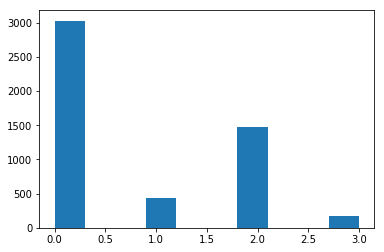

In [105]:
plt.hist(np.isnan(X_train).argmax(axis=1)) # Sequence length distribution
plt.figure()
plt.hist(y_train[:, 1]); # Class distribution

In [106]:
# Add channel dimension
X_train = X_train[:, :, np.newaxis]
X_test = X_test[:, :, np.newaxis]

# Convert to one-hot
y_train = keras.utils.to_categorical(y_train[:, 1])

# Create validations set
X_train, X_val, Y_train, Y_val = train_test_split(X_train, y_train, test_size=0.1, random_state=42)

In [107]:
def feed(X, y, training=True, shorten=False, lengthen=False, batch_size=128, spectrogram=False):
    seqlens = np.isnan(X[:,:,0]).argmax(axis=1)
    seqlens[seqlens == 0] = X.shape[1]
    
    if shorten:
        target_len = seqlens.min()
        print('Shortening to %d' % target_len)
    
    # Loop over epochs
    while True:
        idx = np.arange(X.shape[0])
        
        if training:
            np.random.shuffle(idx)
                
        # Loop over batches
        for k in range(0, X.shape[0], batch_size):        
            X_batch, y_batch, lens_batch = [], [], []

            # Loop over examples
            for j in range(k, min(X.shape[0], k+batch_size)):
                i = idx[j]
                example = np.copy(X[i])
                seqlen = seqlens[i]

                if training:
                    while True:
                        # Randomly rescale
                        example = transformations.random_resample(example[np.newaxis,:seqlen,0]).T
                        seqlen = np.isnan(example).argmax()
                        if seqlen == 0: seqlen = example.shape[0]
                        if not shorten or seqlen >= target_len: break
                        example = np.copy(X[i])
                        seqlen = seqlens[i]
                        
                    # Randomly set runs to zero
                    for _ in range(int(float(seqlens[i]) / float(X.shape[1]) * 50.)):
                        blen = np.random.randint(50, 250)
                        pos = np.random.randint(seqlen-blen)
                        example[pos:pos+blen] = 0

                if lengthen:
                    # Repeat sequence to fill padding
                    example = np.tile(example[:seqlen], [int(np.ceil(X.shape[1] / seqlen)),1])
                    example = example[:X.shape[1]]
                elif shorten:
                    # Choose random window to shorten sequence
                    offset = np.random.randint(seqlen - target_len + 1)
                    example = example[offset:offset+target_len]

                if spectrogram:
                    # Convert into spectrogram
                    example = transformations.spectrogram(example[np.newaxis,:seqlen,0], 32, noverlap=None)[0]
                    
                X_batch.append(example)
                lens_batch.append(example.shape[0])
                
                if y is not None:
                    y_batch.append(y[i])
                    
            pad_len = max(lens_batch)
            X_batch_padded = np.zeros((len(X_batch), pad_len,) + example.shape[1:])
            for i, ex in enumerate(X_batch):
                X_batch_padded[i, :ex.shape[0]] = ex

            if y is not None:
                yield X_batch_padded, np.array(y_batch)
            else:
                yield X_batch_padded

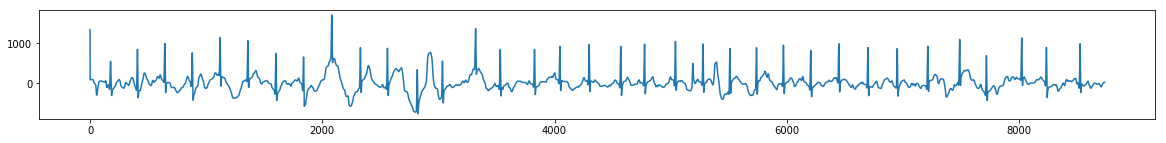

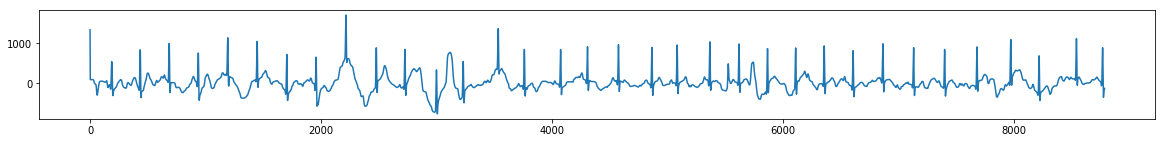

In [108]:
plt.figure(figsize=(20,2))
plt.plot(X_train[456,:,0])

res = transformations.random_resample(X_train[456,:8783,0][np.newaxis,:])
plt.figure(figsize=(20,2))
plt.plot(res[0]);

(20, 613, 17)


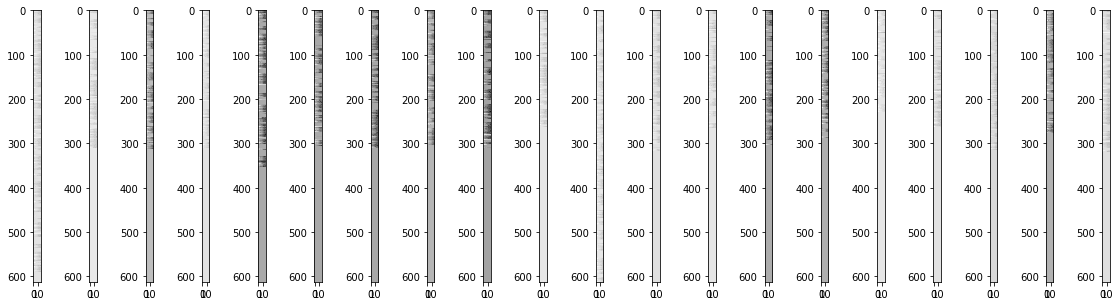

In [109]:
it = feed(X_train, Y_train, training=True, shorten=False, spectrogram=True, batch_size=20)
X_batch = next(it)[0]
print(X_batch.shape)
plt.figure(figsize=(20, 5))
for i in range(20):
    #plt.figure(figsize=(20, 5))
    #plt.plot(examples[0][i])
    
    plt.subplot(1, 20, i+1)
    plt.imshow(X_batch[i], cmap='gray')

In [110]:
model = keras.models.Sequential()
# model.add(layers.Dropout(.5, input_shape=(None, 33, 1)))

for i in [128,256,512]:
    model.add(layers.Conv1D(i, 3, padding='same', input_shape=(None, 17)))
    model.add(layers.Conv1D(i, 3, padding='same'))
    model.add(layers.Conv1D(i, 3, padding='same'))
    model.add(layers.Activation('relu'))
    model.add(keras.layers.normalization.BatchNormalization())
    
    # Maxpool over time only
    model.add(layers.MaxPooling1D(2))

# Global maxpool over time only
model.add(layers.GlobalMaxPooling1D())

model.add(layers.Dense(1024, activation='relu'))
model.add(keras.layers.normalization.BatchNormalization())
model.add(layers.Dense(1024, activation='relu'))
model.add(layers.Dense(4, activation='softmax'))

model.compile(loss='categorical_crossentropy',
              optimizer=keras.optimizers.Adam(0.0001),
              metrics=['accuracy'])

In [111]:
# model = keras.models.Sequential()
# # model.add(layers.Dropout(.5, input_shape=(None, 33, 1)))

# for _ in range(3):
#     model.add(layers.Conv2D(64, 3, padding='same', input_shape=(None, 17, 1)))
#     print(model.output_shape)
#     model.add(layers.Conv2D(64, 3, padding='same'))
#     model.add(layers.Conv2D(64, 3, padding='same'))
#     model.add(layers.Activation('relu'))
#     model.add(keras.layers.normalization.BatchNormalization())
    
#     # Maxpool over time only
#     model.add(layers.Reshape((-1, 17*64)))
#     model.add(layers.MaxPooling1D(2))
#     model.add(layers.Reshape((-1, 17, 64)))

# # Global maxpool over time only
# model.add(layers.Reshape((-1, 17*64)))
# model.add(layers.GlobalMaxPooling1D())

# model.add(layers.Dense(2048, activation='relu'))
# model.add(keras.layers.normalization.BatchNormalization())
# model.add(layers.Dense(2048, activation='relu'))
# model.add(layers.Dense(4, activation='softmax'))

# model.compile(loss='categorical_crossentropy',
#               optimizer='adam',
#               metrics=['accuracy'])

In [113]:
# class Metrics(keras.callbacks.Callback):
#     def on_epoch_end(self, epoch, logs={}):
#         val_predict = model.predict(X_val).argmax(axis=1)
#         val_targ = Y_val.argmax(axis=1)
#         print("f1: %.3f" % f1_score(val_targ, val_predict, average='micro'))

model.fit_generator(feed(X_train, Y_train, spectrogram=True), 
                    steps_per_epoch=np.ceil(X_train.shape[0]/128.), 
                    epochs=4000,
                    validation_data=feed(X_val, Y_val, batch_size=128, spectrogram=True, training=False), 
                    validation_steps=np.ceil(X_val.shape[0]/128.),
                    callbacks=[
                        keras.callbacks.EarlyStopping(monitor='val_acc', patience=50, restore_best_weights=True),
                        keras.callbacks.ModelCheckpoint('weights.{epoch:03d}-{val_acc:.4f}.h5', save_weights_only=True)
                    ])

Epoch 1/4000
36/36 [==============================] - 13s 371ms/step - loss: 1.0443 - acc: 0.5520 - val_loss: 1.0813 - val_acc: 0.5957
Epoch 2/4000
36/36 [==============================] - 10s 273ms/step - loss: 0.9823 - acc: 0.5764 - val_loss: 0.9859 - val_acc: 0.5996
Epoch 3/4000
36/36 [==============================] - 11s 318ms/step - loss: 0.9752 - acc: 0.5735 - val_loss: 0.9592 - val_acc: 0.5918
Epoch 4/4000
36/36 [==============================] - 11s 310ms/step - loss: 0.9477 - acc: 0.5818 - val_loss: 0.9555 - val_acc: 0.6035
Epoch 5/4000
36/36 [==============================] - 11s 301ms/step - loss: 0.9305 - acc: 0.5915 - val_loss: 0.9852 - val_acc: 0.5742
Epoch 6/4000
36/36 [==============================] - 11s 293ms/step - loss: 0.9096 - acc: 0.6007 - val_loss: 1.1888 - val_acc: 0.4648
Epoch 7/4000
36/36 [==============================] - 11s 295ms/step - loss: 0.8564 - acc: 0.6272 - val_loss: 0.8559 - val_acc: 0.6562
Epoch 8/4000
36/36 [==============================] - 1

36/36 [==============================] - 11s 310ms/step - loss: 0.5373 - acc: 0.7818 - val_loss: 0.5344 - val_acc: 0.7871
Epoch 62/4000
36/36 [==============================] - 12s 331ms/step - loss: 0.5486 - acc: 0.7735 - val_loss: 0.5637 - val_acc: 0.7676
Epoch 63/4000
36/36 [==============================] - 11s 306ms/step - loss: 0.5313 - acc: 0.7794 - val_loss: 0.4763 - val_acc: 0.8145
Epoch 64/4000
36/36 [==============================] - 11s 304ms/step - loss: 0.5314 - acc: 0.7891 - val_loss: 0.5294 - val_acc: 0.7988
Epoch 65/4000
36/36 [==============================] - 11s 307ms/step - loss: 0.5418 - acc: 0.7768 - val_loss: 0.5579 - val_acc: 0.7930
Epoch 66/4000
36/36 [==============================] - 11s 305ms/step - loss: 0.5236 - acc: 0.7885 - val_loss: 0.5740 - val_acc: 0.7656
Epoch 67/4000
36/36 [==============================] - 11s 318ms/step - loss: 0.5267 - acc: 0.7839 - val_loss: 0.5371 - val_acc: 0.8086
Epoch 68/4000
36/36 [==============================] - 10s 290

36/36 [==============================] - 11s 295ms/step - loss: 0.4864 - acc: 0.8035 - val_loss: 0.5903 - val_acc: 0.7734
Epoch 122/4000
36/36 [==============================] - 11s 297ms/step - loss: 0.4824 - acc: 0.8087 - val_loss: 0.5768 - val_acc: 0.7578
Epoch 123/4000
36/36 [==============================] - 11s 299ms/step - loss: 0.4731 - acc: 0.8100 - val_loss: 0.6284 - val_acc: 0.7578
Epoch 124/4000
36/36 [==============================] - 10s 291ms/step - loss: 0.4869 - acc: 0.8080 - val_loss: 0.5013 - val_acc: 0.7930
Epoch 125/4000
36/36 [==============================] - 11s 306ms/step - loss: 0.4654 - acc: 0.8118 - val_loss: 0.4794 - val_acc: 0.8145
Epoch 126/4000
36/36 [==============================] - 11s 298ms/step - loss: 0.4755 - acc: 0.8078 - val_loss: 0.6261 - val_acc: 0.7383
Epoch 127/4000
36/36 [==============================] - 11s 296ms/step - loss: 0.4784 - acc: 0.8061 - val_loss: 0.6722 - val_acc: 0.7227
Epoch 128/4000
36/36 [==============================] - 

In [13]:
# model.save_weights('weights.h5')

In [15]:
# Evaluate
model.evaluate_generator(feed(X_val, Y_val, batch_size=128, spectrogram=True, training=False), 
                         steps=np.ceil(X_val.shape[0] / 128))

[0.45072056353092194, 0.83984375]

In [73]:
# Predict
model.load_weights('weights.060-0.8145.h5')
y_test = model.predict_generator(feed(X_test, None, training=False, spectrogram=True, batch_size=128), 
                                 steps=np.ceil(X_test.shape[0] / 128.))
assert y_test.shape[0] == X_test.shape[0]
np.savetxt("Y_test_cnn2.csv", np.stack(( np.arange(X_test.shape[0]), y_test.argmax(axis=1) ), axis=1), 
           delimiter=",", header="id,y", fmt='%d', comments='')

In [114]:
# Predict ensemble
filenames = [
'weights.040-0.8105.h5',
'weights.055-0.8105.h5',
'weights.063-0.8145.h5',
'weights.069-0.8105.h5',
'weights.077-0.8203.h5',
'weights.079-0.8105.h5',
'weights.080-0.8242.h5',
'weights.105-0.8242.h5',
'weights.117-0.8125.h5',
'weights.125-0.8145.h5',
'weights.129-0.8145.h5'
]

Y_test_ensemble = np.zeros((X_test.shape[0], len(filenames), 4))
Y_val_ensemble = np.zeros((X_val.shape[0], len(filenames), 4))
for i, f in enumerate(filenames):
    model.load_weights(f)
    Y_test_ensemble[:, i] = model.predict_generator(feed(X_test, None, training=False, spectrogram=True, batch_size=128), 
                                 steps=np.ceil(X_test.shape[0] / 128.))
    Y_val_ensemble[:, i] = model.predict_generator(feed(X_val, None, training=False, spectrogram=True, batch_size=128), 
                             steps=np.ceil(X_val.shape[0] / 128.))
    print '.',

. . . . . . . . . . .


In [127]:
# Hard voting
Y_test = [np.bincount(Y_test_ensemble[i].argmax(axis=1).astype(int)).argmax() for i in range(Y_test_ensemble.shape[0])]

# Soft voting
# Y_test = Y_test_ensemble.sum(axis=1).argmax(axis=1)

# Weighted voting
# import sklearn.linear_model
# reg = sklearn.linear_model.LinearRegression().fit(Y_val_ensemble.reshape((X_val.shape[0], -1)), Y_val)
# Y_test = reg.predict(Y_test_ensemble.reshape((X_test.shape[0], -1))).argmax(axis=1)

assert len(Y_test) == X_test.shape[0]
np.savetxt("Y_test_cnn-ensemble3-hard.csv", np.stack(( np.arange(X_test.shape[0]), Y_test ), axis=1), 
           delimiter=",", header="id,y", fmt='%d', comments='')

In [128]:
Y_test[:5]

[0, 0, 2, 0, 0]

In [56]:
y_test[:5].argmax(axis=1)

array([0, 0, 2, 0, 0])